In [1]:
%load_ext autoreload
%autoreload 2

# Pagel's lambda for growth rates
import numpy as np
import pandas as pd

import ete3
from tqdm import tqdm

from src.phylogenetic_signal import PagelsLambda

# Global variables
GG_TREE = "./greengenes/data/gg_13_5_otus_99_annotated.tree"
TOP_N = 100

/home/phil/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Distill into iHMP-agnostic function:

from src.ihmp import get_diffs

ibd_diffs = get_diffs("ibd", top_n=TOP_N)
moms_diffs = get_diffs("moms", top_n=TOP_N)
t2d_diffs = get_diffs("t2d", top_n=TOP_N)

In [3]:
# Compute lambda values for each iHMP dataset:

from src.ihmp import pagels_dataframe

ibd_pls = pagels_dataframe(ibd_diffs, GG_TREE)
ibd_pls.to_csv(f"./results/ibd_pls_top{TOP_N}.csv")

moms_pls = pagels_dataframe(moms_diffs, GG_TREE)
moms_pls.to_csv(f"./results/moms_pls_top{TOP_N}.csv")

t2d_pls = pagels_dataframe(t2d_diffs, GG_TREE)
t2d_pls.to_csv(f"./results/t2d_pls_top{TOP_N}.csv")


69
6765
2071


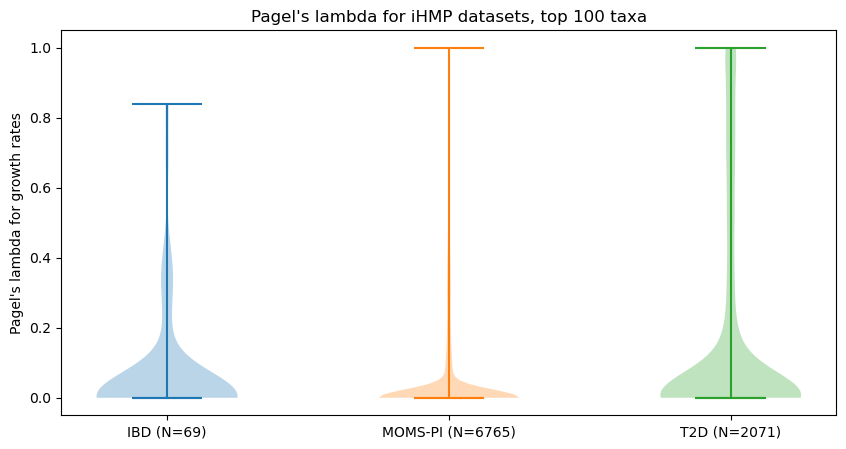

In [ ]:
# Violin plot

import matplotlib.pyplot as plt
import pandas as pd

ibd_pls = pd.read_csv(f"./results/ibd_pls_top{TOP_N}.csv")
ibd_pls["dataset"] = "IBD"

moms_pls = pd.read_csv(f"./results/moms_pls_top{TOP_N}.csv")
moms_pls["dataset"] = "MOMS-PI"

t2d_pls = pd.read_csv(f"./results/t2d_pls_top{TOP_N}.csv")
t2d_pls["dataset"] = "T2D"

# Combine 3 series into one dataframe
pls = pd.concat([ibd_pls, moms_pls, t2d_pls])

# Plot
plt.figure(figsize=(10, 5))
datasets = pls["dataset"].unique()
for i, dataset in enumerate([ibd_pls, moms_pls, t2d_pls]):
    plt.violinplot(
        dataset["lambda"].dropna().values,
        showmedians=True,
        positions=[i + 1],
    )

print(len(ibd_pls["lambda"].dropna().values)) # 69
print(len(moms_pls["lambda"].dropna().values)) # 6765
print(len(t2d_pls["lambda"].dropna().values)) # 2071

plt.xticks(range(1, 4), ["IBD (N=69)", "MOMS-PI (N=6765)", "T2D (N=2071)"])
plt.ylabel("Pagel's lambda for growth rates")
plt.title(f"Pagel's lambda for iHMP datasets, top {TOP_N} taxa")
plt.show()

In [ ]:
# Same thing but grouped by body site

# Only need the plotting part, though:
plt.figure(figsize=(10, 5))
datasets = pls["dataset"].unique()
labels = []
position = 1
for dataset, name in zip([ibd_pls, moms_pls, t2d_pls], ["IBD", "MOMS-PI", "T2D"])"]:
    for site in dataset["site"].unique():
        lambdas = dataset[dataset["site"] == site]["lambda"].dropna().values
        if len(lambdas) > 0: # Need to check nonzero AFTER dropna() as well
            labels.append(f"{site} (N={len(lambdas)})")
            plt.violinplot(
                lambdas, showmedians=True, positions=[position],
            )
            position += 1

plt.xticks(range(1, position), labels)
plt.ylabel("Pagel's lambda for growth rates")
plt.title(f"Pagel's lambda for iHMP datasets, top {TOP_N} taxa")
plt.show()